In [95]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms.functional as F1
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
class customDataset(Dataset):
    def __init__(self, videoList, classInd, subsample, size):
        with open(videoList) as f:
            self.videoList = f.read().splitlines()
        with open(classInd) as f:
            classList = f.read().splitlines()
            self.encodeClass = {x.split(" ")[1] : int(x.split(" ")[0]) - 1 for x in classList}
            self.decodeClass = {int(x.split(" ")[0]) -1 : x.split(" ")[1] for x in classList}
        self.subsample = subsample
        self.n = len(classList)
        self.size = size

    def __len__(self):
        return len(self.videoList)

    def __getitem__(self, idx):
        videoPath = self.videoList[idx].split(" ")[0]
        label = self.encodeClass[videoPath.split("/")[0]]
        video, _, _ = torchvision.io.read_video("./UCF-101/"+videoPath, pts_unit='sec', output_format="TCHW")
        video = video[np.linspace(0, len(video)-1, self.subsample, dtype="int")]
        if video.shape[2:] != self.size:
            video = F1.resize(video, size=self.size, antialias=False)
        video = F1.rgb_to_grayscale(video).transpose(0,1)
        return video/255, label

In [3]:
class Net(nn.Module):
    def __init__(self, dropoutP, fc1P):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 32, 3)
        self.conv2 = nn.Conv3d(32, 64, 3)
        self.conv3 = nn.Conv3d(64, 96, 3)
        self.conv4 = nn.Conv3d(96, 64, 1, stride=2)
        self.dropout = nn.Dropout(p=dropoutP)
        self.maxpool = nn.MaxPool3d((1, 3, 3))
        self.fc1 = nn.Linear(fc1P, 128)
        self.fc2 = nn.Linear(128, trainingData.n)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def accuracy(outputs, labels):
    with torch.no_grad():
        eq = outputs.argmax(1).to("cpu") == labels
        return (eq.sum() / eq.numel()).numpy()

In [4]:
# a, b = customDataset("customTrainList.txt", "classInd.txt", 8)[500]
# plt.imshow(a[:, 0, :, :].permute(1, 2, 0).cpu().numpy())
# print(trainingData.decodeClass[b])

In [44]:
params = {0 : [(61, 61), 10, 0.1, 128],
          1 : [(122, 122), 9, 0.2, 512],
          2 : [(244, 244), 8, 0.3, 1024]}

In [6]:
history = []
for i in range(3):
    torch.cuda.empty_cache()
    size, subsample, dropoutP, fc1P = params[i]

    trainingData = customDataset("customTrainList.txt", "classInd.txt", subsample, size)
    testData = customDataset("customTestList.txt", "classInd.txt", subsample, size)

    trainDataloader = DataLoader(trainingData, batch_size=12, shuffle=True, pin_memory=True)
    validationDataloader = DataLoader(testData, batch_size=12, shuffle=False, pin_memory=True)

    net = Net(dropoutP, fc1P).to("cuda")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters())


    lossTrainHist = []
    lossValidationHist = []
    accuracyTrainHist = []
    accuracyValidationHist = []
    minLoss = float('inf')

    for epoch in tqdm(range(50)):

        runningTrainLoss = 0.0
        runningValidationLoss = 0.0

        net.train()
        for i, data in enumerate(trainDataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = net(inputs.to("cuda"))

            lossTrain = criterion(outputs, labels.to("cuda"))
            lossTrain.backward()
            optimizer.step()

            runningTrainLoss += lossTrain.item()
            accuracyTrainHist.append(accuracy(outputs, labels))

        lossTrainHist.append(runningTrainLoss/(i+1))

        net.eval()
        for i, data in enumerate(validationDataloader, 0):
            inputs, labels = data
            with torch.no_grad():
                outputs = net(inputs.to("cuda"))

            lossValidation = criterion(outputs, labels.to("cuda"))

            runningValidationLoss += lossValidation.item()
            accuracyValidationHist.append(accuracy(outputs, labels))

        lossValidationHist.append(runningValidationLoss/(i+1))

        if minLoss>lossValidationHist[epoch]:
            minLoss = lossValidationHist[epoch]
            bestWeights = net.state_dict().copy()
            epochSave = epoch
    torch.save(bestWeights, str(i)+"w.pth")
    history.append([lossTrainHist, lossValidationHist, accuracyTrainHist, accuracyValidationHist, minLoss, epochSave])

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [2:37:15<00:00, 188.72s/it]


minloss 0.6891640002140775 [(61, 61), 10, 0.1, 128]


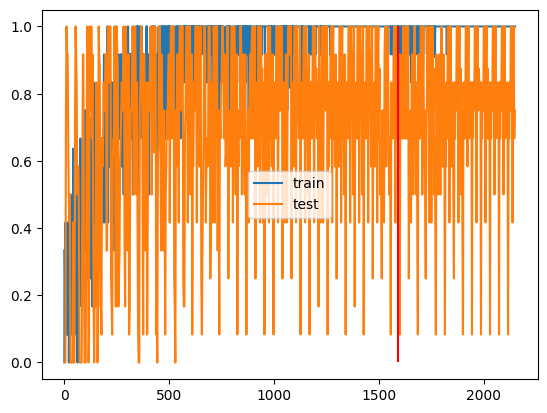

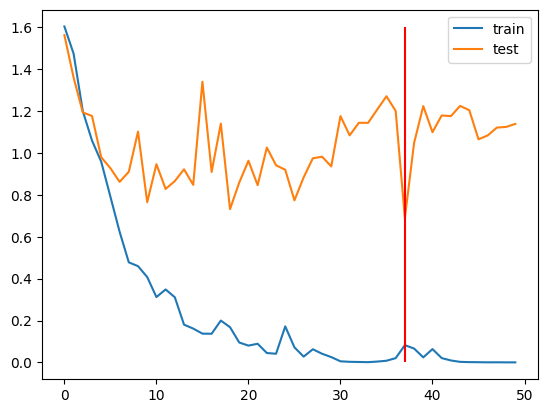

minloss 0.6007313756563235 [(122, 122), 9, 0.2, 512]


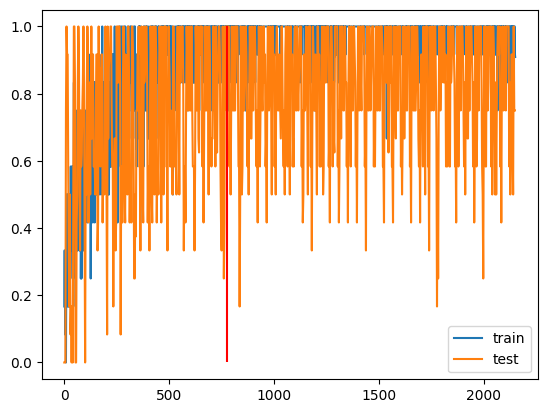

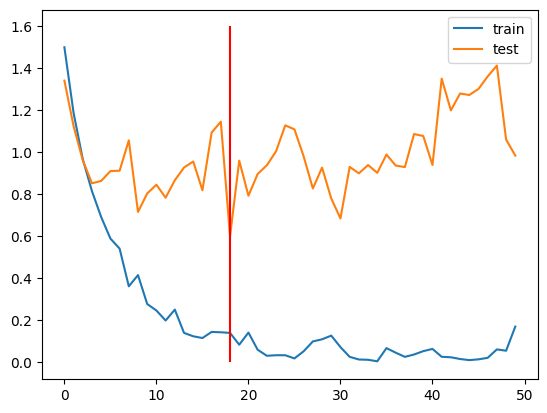

minloss 0.4616063244175166 [(244, 244), 8, 0.3, 1024]


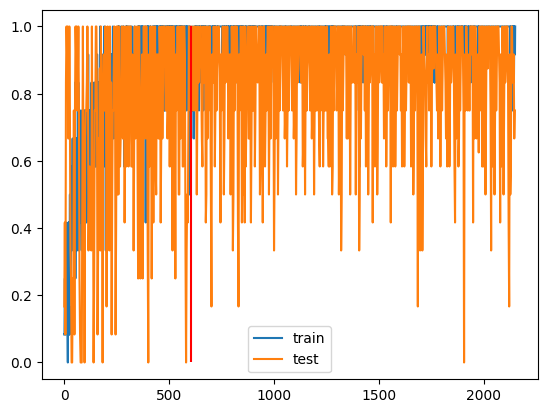

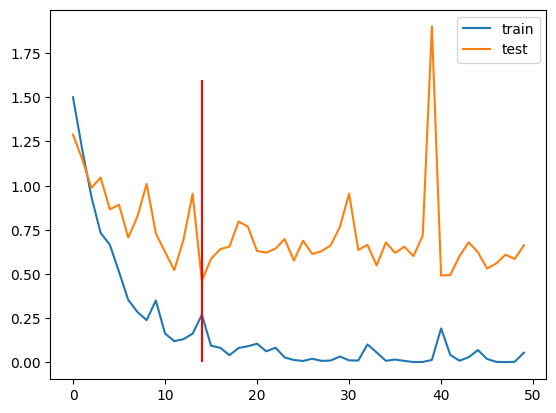

In [58]:
for i, [lossTrainHist, lossValidationHist, accuracyTrainHist, accuracyValidationHist, minLoss, epochSave] in enumerate(hist):
    print( "minloss", minLoss, params[i])
    plt.plot(np.arange(len(accuracyTrainHist)),accuracyTrainHist)
    plt.plot(np.arange(len(accuracyValidationHist))*2.6875,accuracyValidationHist)
    plt.vlines(len(accuracyTrainHist)/50*epochSave,0,1, colors="red")
    plt.legend(["train","test"])
    plt.show()
    plt.plot(range(len(lossTrainHist)),lossTrainHist)
    plt.plot(range(len(lossValidationHist)),lossValidationHist)
    plt.vlines(epochSave,0,1.6, colors="red")
    plt.legend(["train","test"])
    plt.show()

In [94]:
torch.cuda.empty_cache()
net = Net(0.1, 1024).to("cuda")
net.load_state_dict(torch.load("./15w.pth"))
testDataset = customDataset("customTest4List.txt", "classInd.txt", 8, (244, 244))
testDataLoader = DataLoader(testDataset, batch_size=20, shuffle=False, pin_memory=True)

net.eval()
inputs, labels = next(iter(testDataLoader))
with torch.no_grad():
    outputs = net(inputs.to("cuda"))
accuracy(outputs, labels)

array(0.8, dtype=float32)

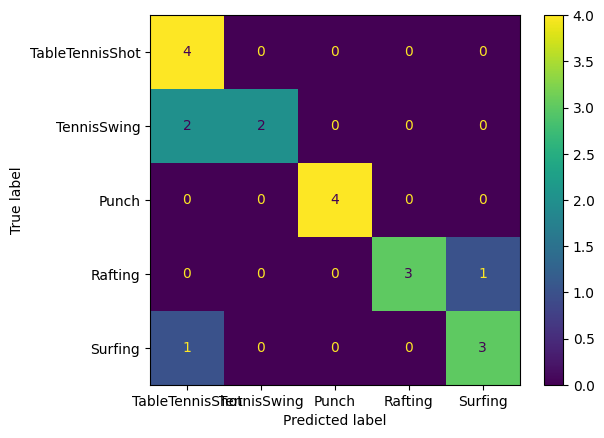

In [108]:
disp = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(labels.cpu().numpy(),outputs.argmax(1).unsqueeze(1).cpu().numpy(),labels=list(range(5))),
                              display_labels=['TableTennisShot', 'TennisSwing', 'Punch', 'Rafting', 'Surfing'])

disp.plot()

plt.show()

In [114]:
class datasetStats(Dataset):
    def __init__(self, videoList):
        with open(videoList) as f:
            self.videoList = f.read().splitlines()

    def __len__(self):
        return len(self.videoList)

    def __getitem__(self, idx):
        videoPath = self.videoList[idx].split(" ")[0]
        video, _, _ = torchvision.io.read_video("./UCF-101/"+videoPath, pts_unit='sec', output_format="TCHW")
        return video.shape[0]

In [117]:
stats = datasetStats("customTrainList.txt")
videoFrameSize = []
numofvideos = len(stats)
for i in range(len(stats)):
    videoFrameSize.append(stats[i])
print("train frame size mean", np.mean(videoFrameSize), numofvideos)
stats = datasetStats("customTestList.txt")
videoFrameSize = []
numofvideos = len(stats)
for i in range(len(stats)):
    videoFrameSize.append(stats[i])
print("test frame size mean", np.mean(videoFrameSize), numofvideos)

train frame size mean 205.76893203883495 515
test frame size mean 177.56914893617022 188


In [138]:
trueLabel

array([1., 0., 0., 0., 0.])

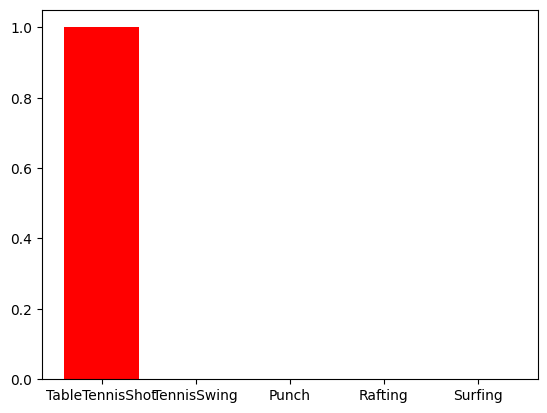

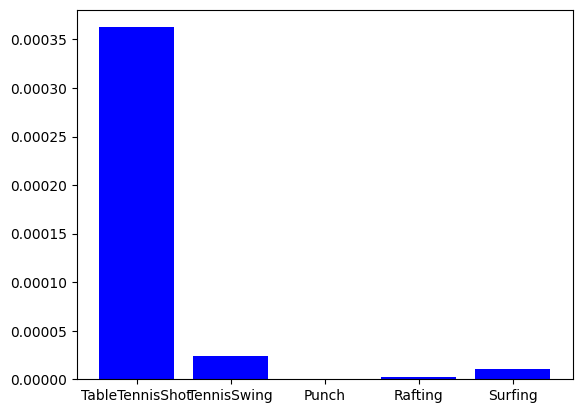

*********************************************************************************************


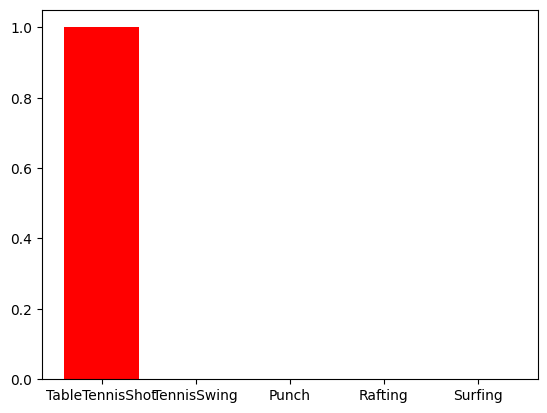

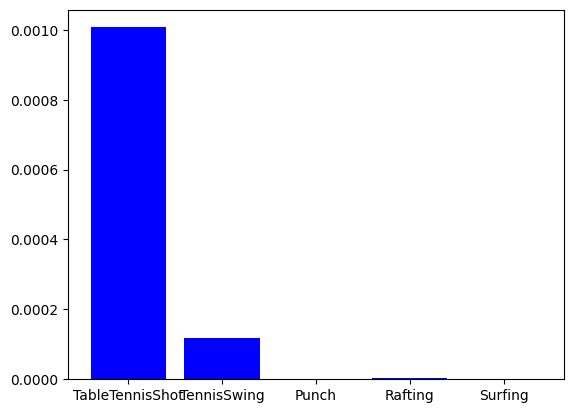

*********************************************************************************************


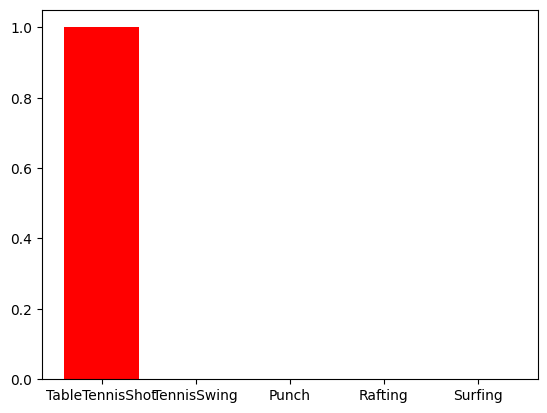

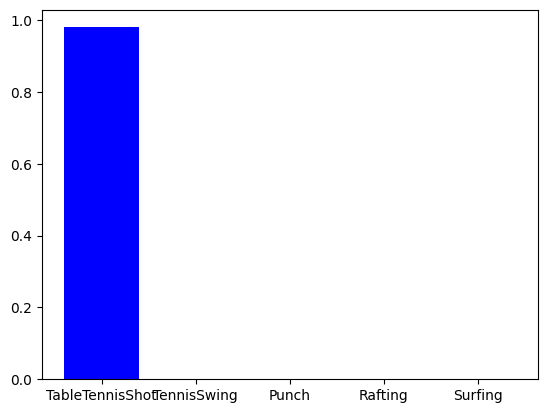

*********************************************************************************************


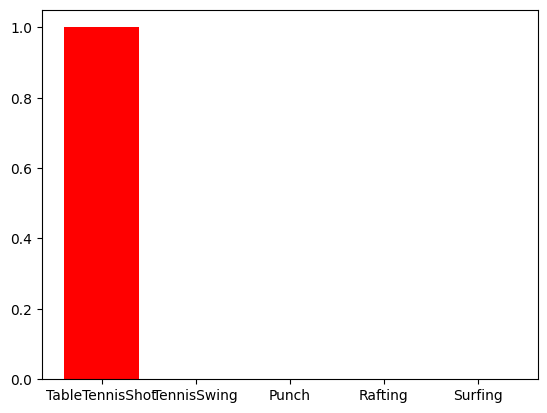

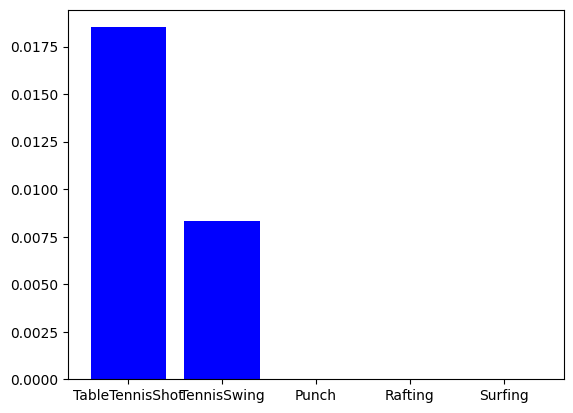

*********************************************************************************************


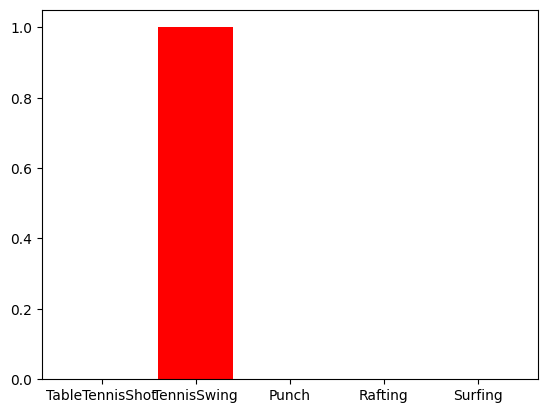

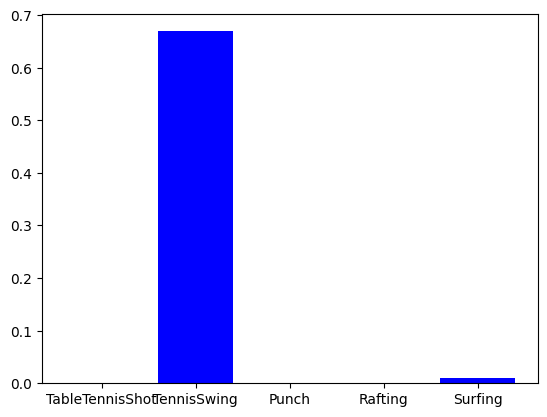

*********************************************************************************************


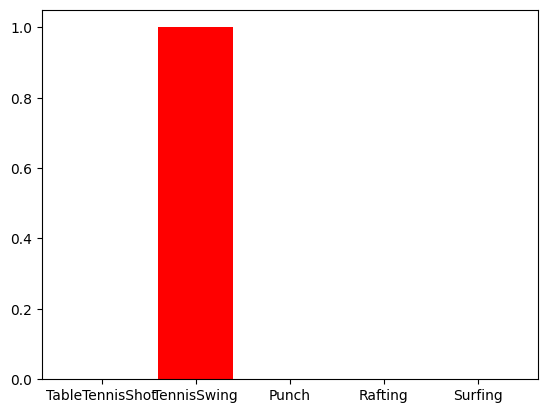

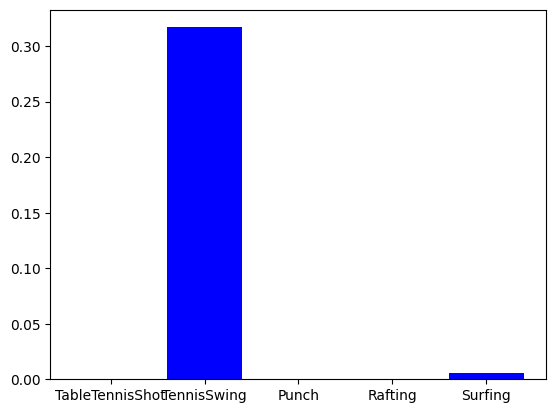

*********************************************************************************************


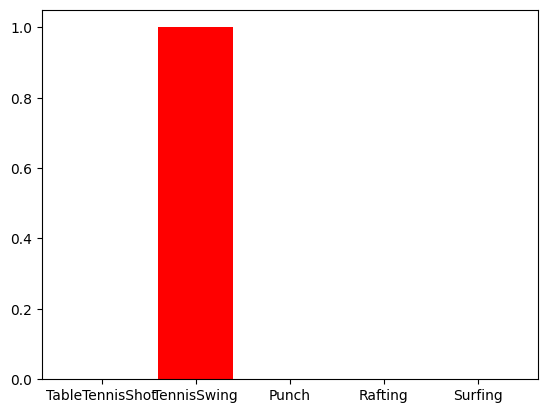

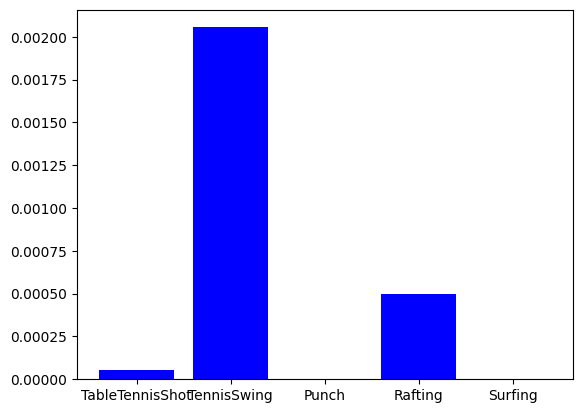

*********************************************************************************************


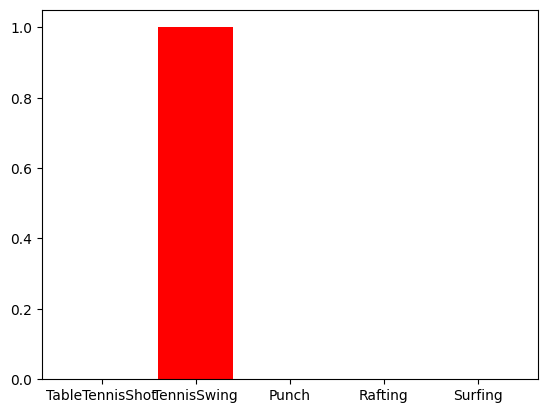

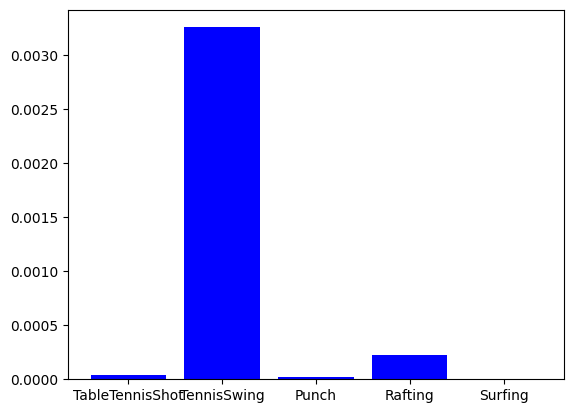

*********************************************************************************************


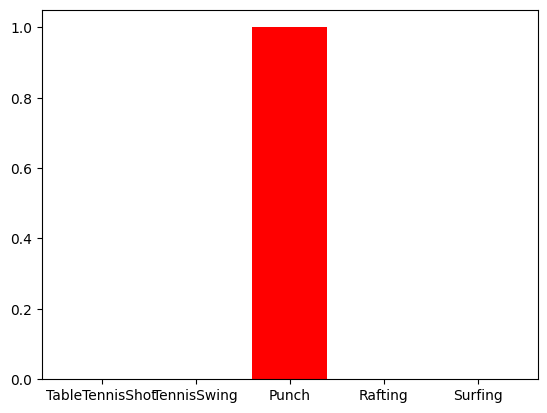

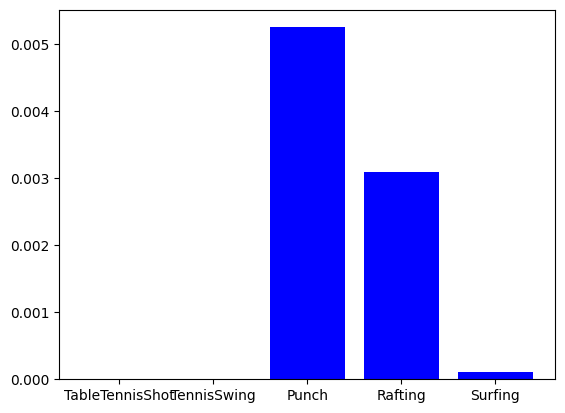

*********************************************************************************************


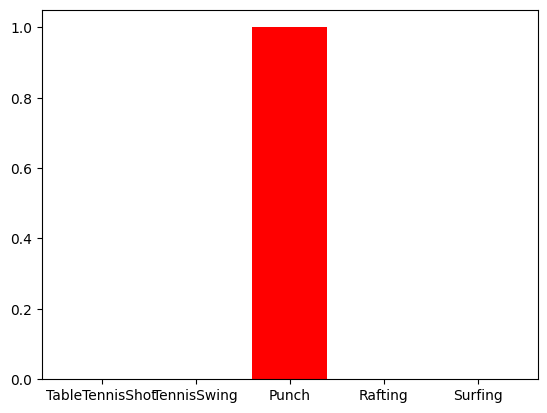

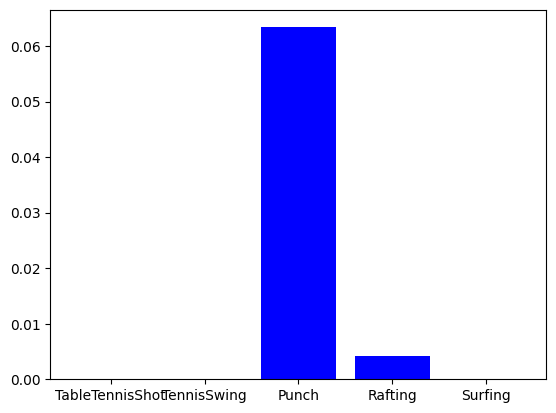

*********************************************************************************************


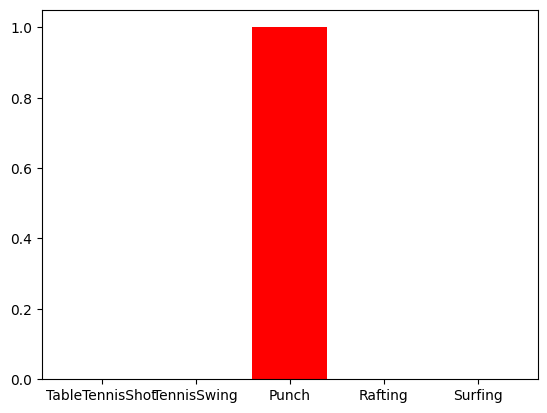

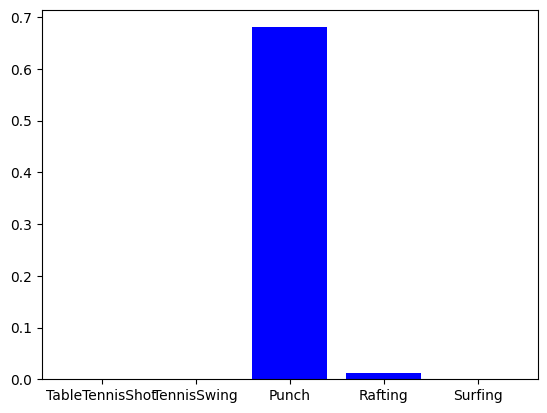

*********************************************************************************************


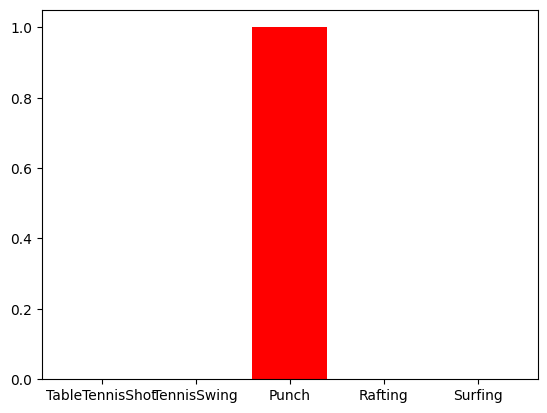

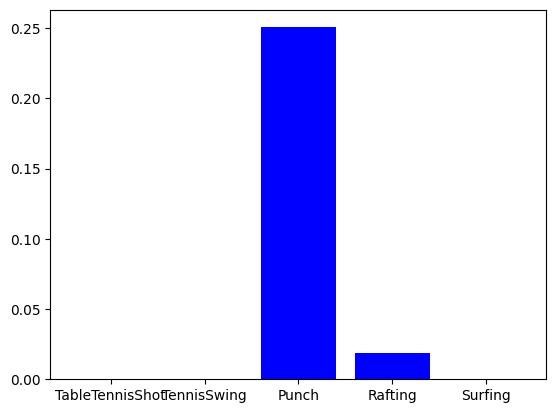

*********************************************************************************************


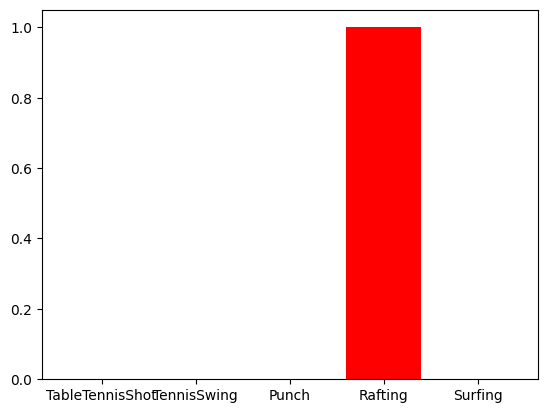

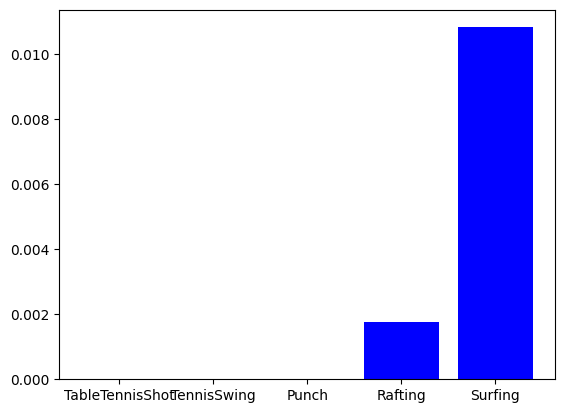

*********************************************************************************************


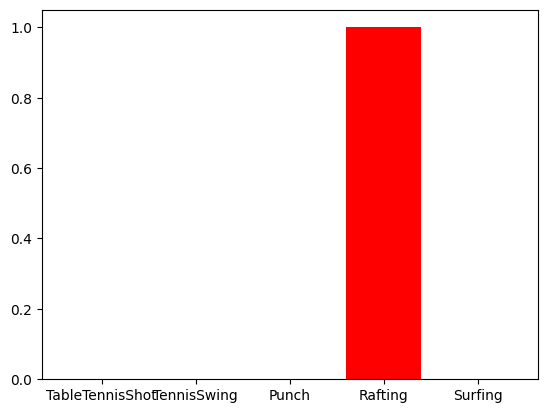

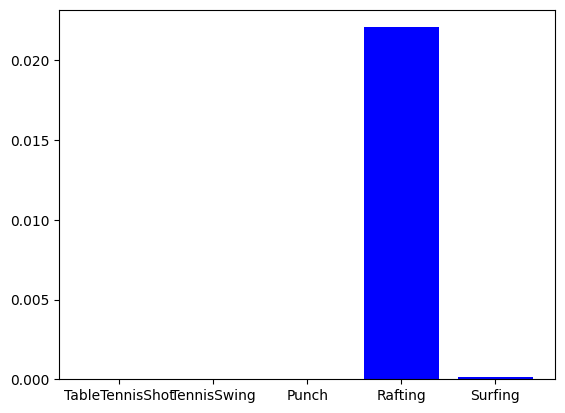

*********************************************************************************************


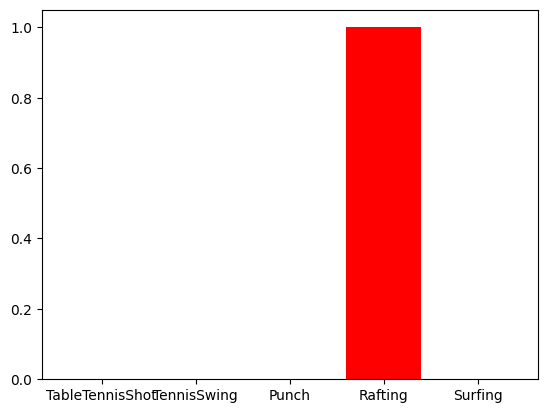

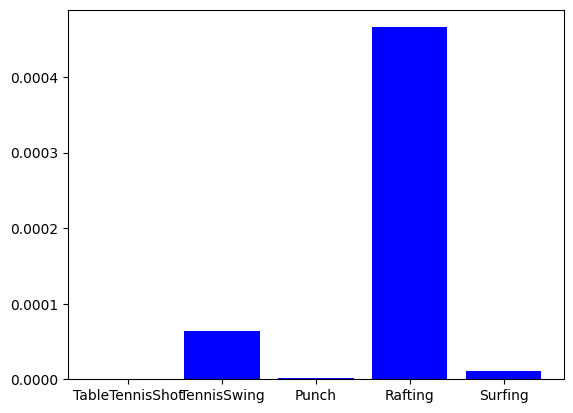

*********************************************************************************************


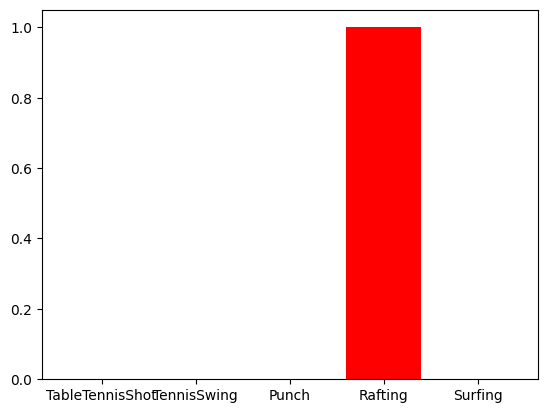

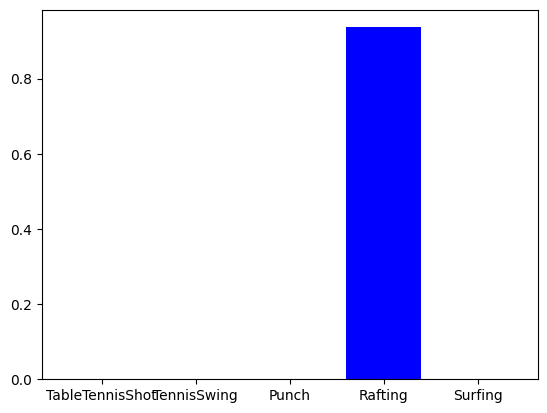

*********************************************************************************************


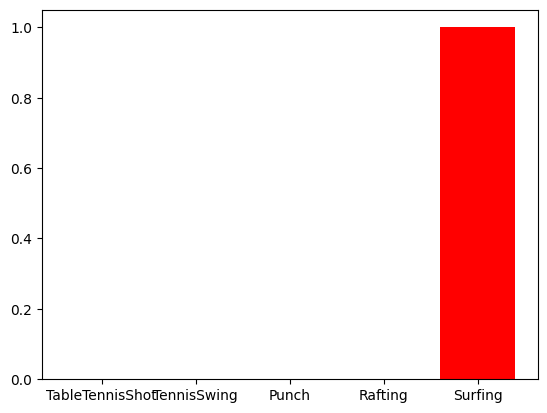

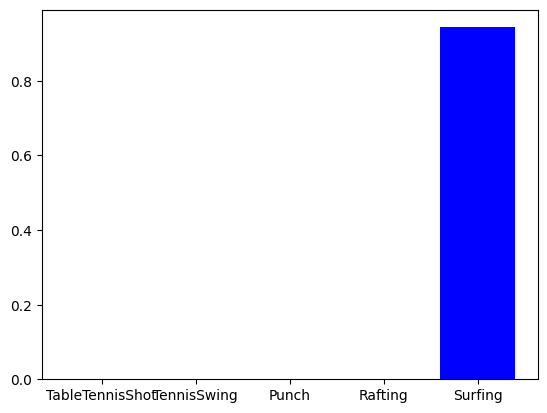

*********************************************************************************************


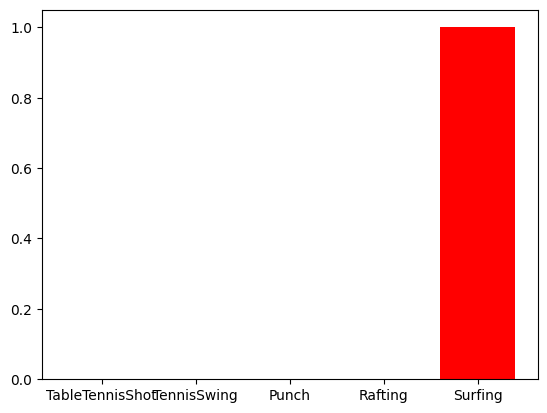

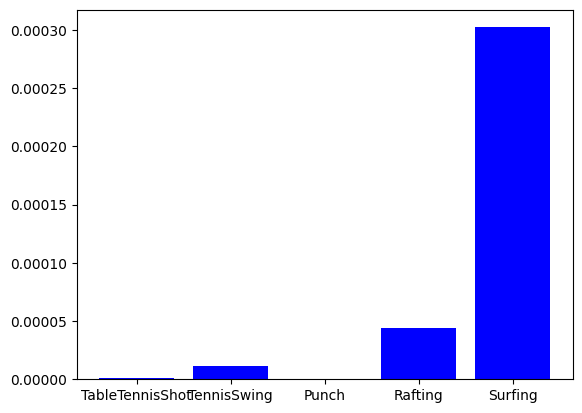

*********************************************************************************************


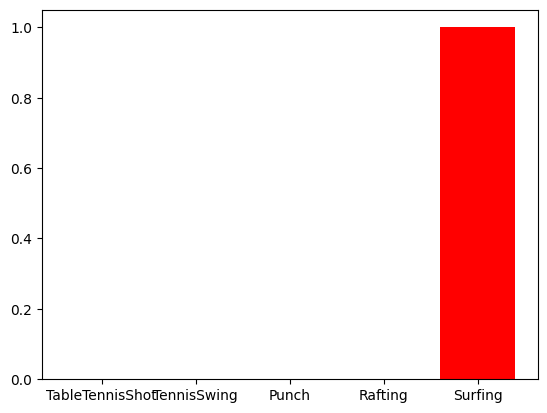

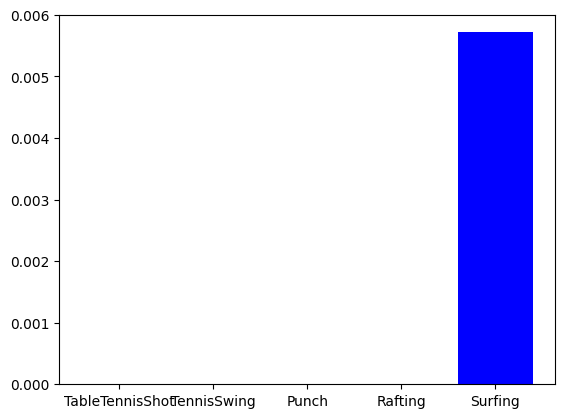

*********************************************************************************************


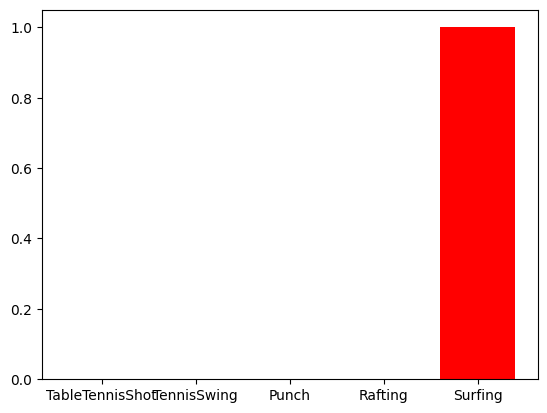

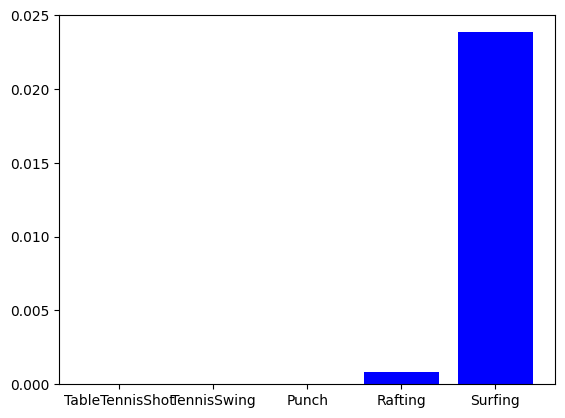

*********************************************************************************************


In [152]:
for i in range(20):
    trueLabel = np.zeros(5)
    trueLabel[labels[i]] = 1
    plt.bar(['TableTennisShot', 'TennisSwing', 'Punch', 'Rafting', 'Surfing'], trueLabel, color="red")
    plt.show()
    plt.bar(['TableTennisShot', 'TennisSwing', 'Punch', 'Rafting', 'Surfing'], outputs.softmax(0).cpu().numpy()[i], color="blue")
    plt.show()
    print("*********************************************************************************************")